# Interest Rate models

In [1]:
import sys, os, ipynbname
NOTEBOOK_NAME = f"{ipynbname.name()}.ipynb"
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(NOTEBOOK_NAME), os.path.pardir)))

In [2]:
# Main functions
from src.Constants import *
from src.Utils import *

# Model simulation
from src.RatesModel import *
from src.Vasicek import *
from src.CIR import *
from src.HullWhite import *

## Vasicek

In [3]:
# Default Vasicek model
model = Vasicek(0.01875, 0.20, 0.01, 0.012) # r0, kappa, theta, sigma

In [4]:
# Displaying information on Vasicek model
model

Vasicek model (r0 = 0.01875, kappa = 0.2, theta = 0.01, eta = 0.012))

In [5]:
# Casting the results into a pandas DataFrame
df = Utils.cast_df(model.simulate_euler(T=3, N = 1000))

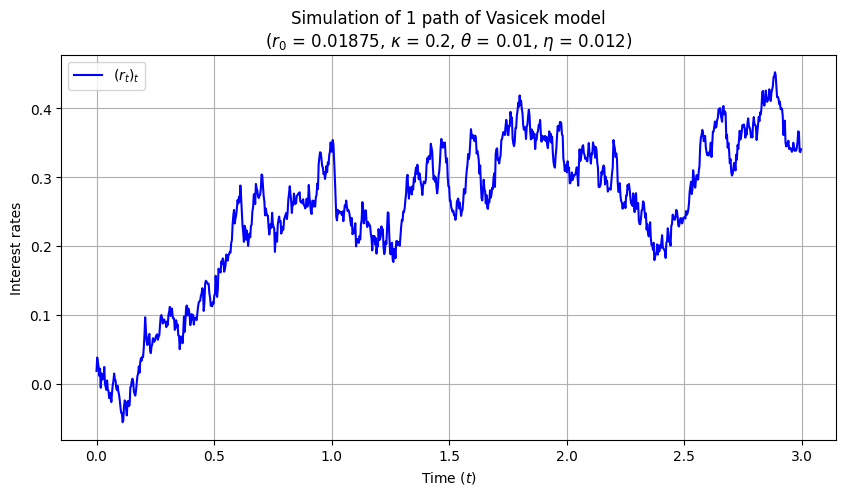

In [6]:
# Simulation of a trajectory
_ = df.plot(color="blue", x="t", y ="r", label="$(r_t)_t$")
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of 1 path of Vasicek model\n{model.get_parameter_string()}")
_ = plt.legend()

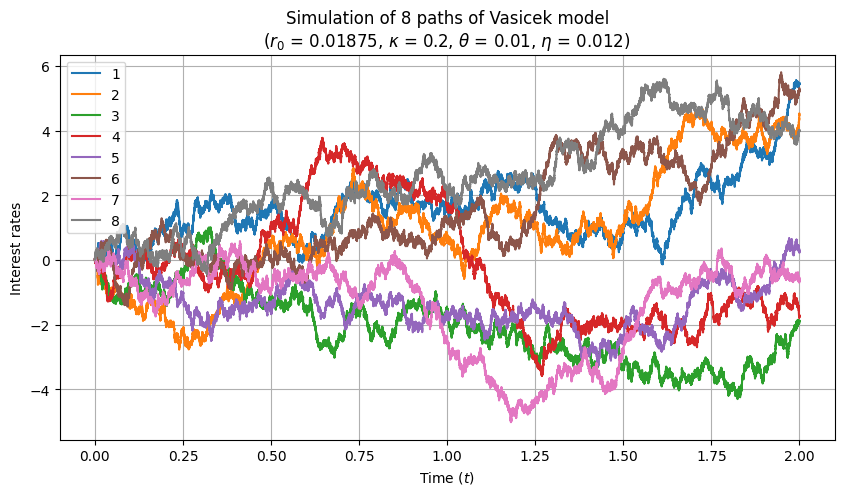

In [7]:
# Simulation of several trajectories
NB_TRAJECTORIES = 8
_ = Utils.cast_df(model.simulate_paths(NB_TRAJECTORIES, T = 2)).T.plot(x = 0, y = list(range(1, NB_TRAJECTORIES + 1)))
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of {NB_TRAJECTORIES} paths of Vasicek model\n{model.get_parameter_string()}")
_ = plt.legend()

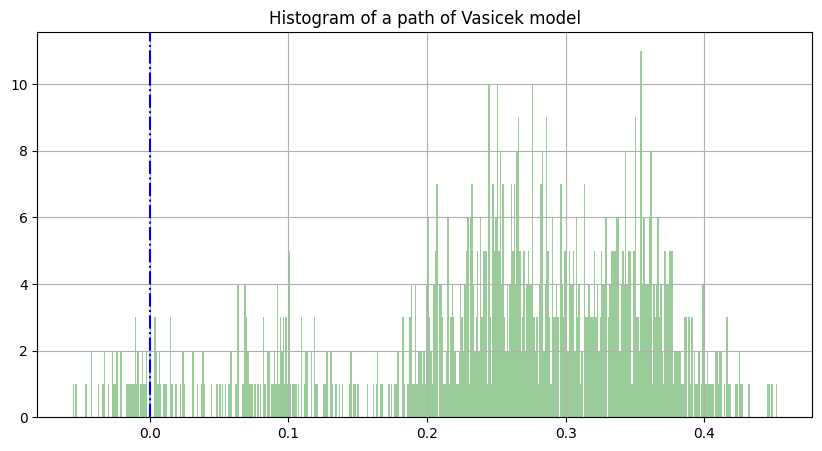

In [8]:
# Histogram of a path
_ = df["r"].hist(bins=int(5e2), color="green", alpha=0.4)
_ = plt.title("Histogram of a path of Vasicek model")
_ = plt.axvline(x = 0, ls = "-.", color="blue")

In [9]:
# Normality test (Shapiro-Wilk + Jarque-Bera)
TEST_THRESHOLD_ALPHA = 5e-2 # Threshold for p-value

# Definition of normality tests (Shapiro-Wilf + Jarque-Bera)
normtest_shapiro = lambda x: scipy.stats.shapiro(x).pvalue > TEST_THRESHOLD_ALPHA 
normtest_jarquebera = lambda x:scipy.stats.jarque_bera(x).pvalue > TEST_THRESHOLD_ALPHA

## Cox-Ingersoll-Ross (CIR)

In [10]:
# Default CIR model
model = CIR(0.4, 0.20, 0.01, 0.12)

In [11]:
# Displaying information on Vasicek model
model

CIR model (r0 = 0.4, kappa = 0.2, theta = 0.01, sigma = 0.12))

In [16]:
# Casting the results into a pandas DataFrame
df = Utils.cast_df(model.simulate_euler(T=3))

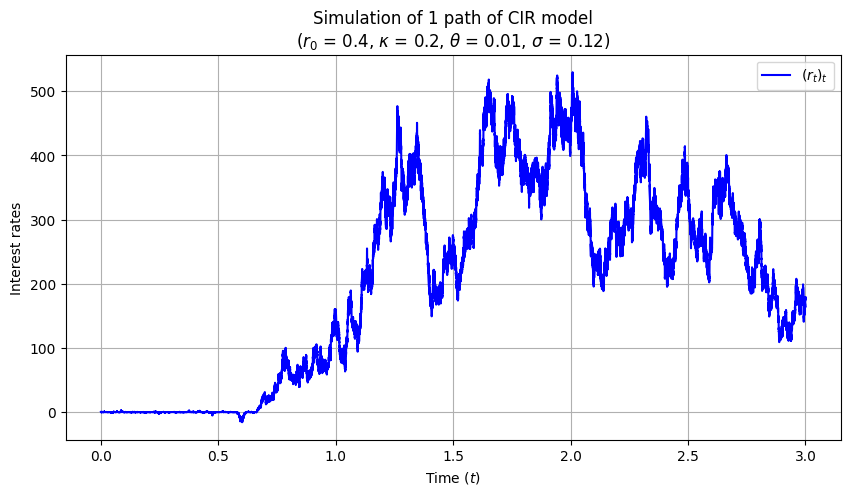

In [17]:
# Simulation of a trajectory
_ = df.plot(color="blue", x="t", y ="r", label="$(r_t)_t$")
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of 1 path of CIR model\n{model.get_parameter_string()}")
model.plot_feller_line()

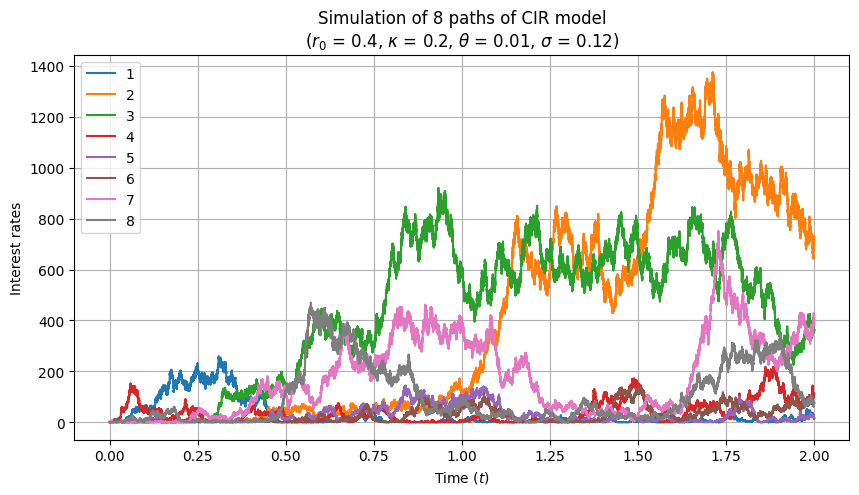

In [18]:
# Simulation of several trajectories
NB_TRAJECTORIES = 8
_ = Utils.cast_df(model.simulate_paths(NB_TRAJECTORIES, scheme=Constants.Scheme.MILSTEIN, T=2)).T.plot(x = 0, y = list(range(1, NB_TRAJECTORIES + 1)))
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of {NB_TRAJECTORIES} paths of CIR model\n{model.get_parameter_string()}")
_ = plt.legend()

**Remark**: Strange behavior of the simulated curves because of the $\sqrt{\bullet}$ with negative rates when Feller condition is not satisfied.
- One alternative is to add $\sqrt{|\bullet|}$ or $(\bullet)_+$ to handle negative rates

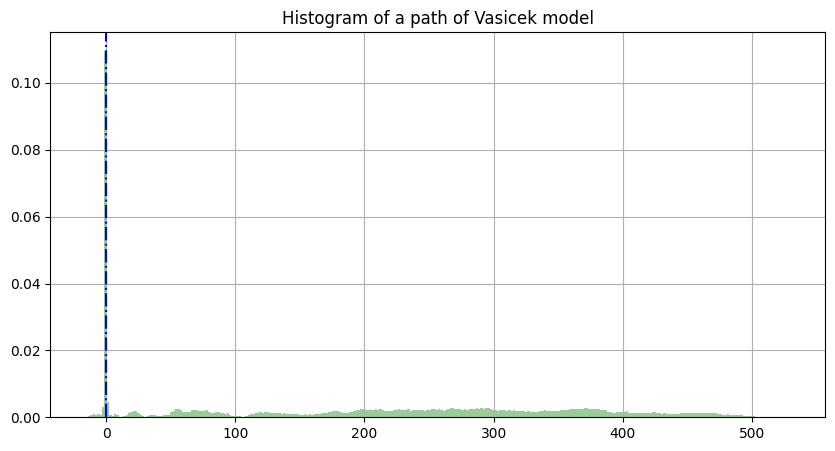

In [19]:
# Histogram of a path
_ = df["r"].hist(bins=int(3e2), color="green", alpha=0.4, density=True)
_ = plt.title("Histogram of a path of Vasicek model")
_ = plt.axvline(x = 0, ls = "-.", color="blue")

## Hull & White (Extended Vasicek)

**Protocol**: Gathering the input term structure of interest rates in order to construct the $\theta : \left[0, T\right] \longrightarrow \mathbb{R}$ deterministic functional.

In [20]:
# Setting up a random evaluation Date
today_date = ql.Date(31,1,2013)
ql.Settings.instance().setEvaluationDate(today_date)

# Setting up the yield termstructure
forward_rate = 0.04875825 #5e-3
rate = ql.SimpleQuote(forward_rate)
rate_handle = ql.QuoteHandle(rate)

# Setting up the day count convention to Actual/365
day_count = ql.Actual365Fixed() 
# day_count = ql.Thirty360(ql.Thirty360.BondBasis)

# Creating the discount curve with its own handler
discount_curve = ql.FlatForward(today_date, rate_handle, day_count)
discount_curve.enableExtrapolation()

# Creating the handler
handler_YTS = ql.YieldTermStructureHandle(discount_curve)

The `yieldTermStructure` object provides an method which gives us the discount factor for a particular date (`QuantLib.Date` object) or time in years (with 0 = `evaluationDate`). This method is called `discount()`.  

We are using the **numpy** method `vectorize` to apply this function on arrays or list of times and then generate a plot of the discount curve.

**Reference**: 
1. https://ipythonquant.wordpress.com/2015/04/04/a-brief-introduction-to-the-quantlib-in-python/

In [21]:
discount = np.vectorize(handler_YTS.discount)
time_horizon = np.arange(0, 10, 1/12)

In [22]:
d = discount(time_horizon)
d

array([1.        , 0.99594506, 0.99190655, 0.98788443, 0.98387861,
       0.97988904, 0.97591565, 0.97195836, 0.96801713, 0.96409187,
       0.96018253, 0.95628905, 0.95241135, 0.94854937, 0.94470306,
       0.94087234, 0.93705716, 0.93325744, 0.92947313, 0.92570417,
       0.92195049, 0.91821204, 0.91448874, 0.91078054, 0.90708737,
       0.90340919, 0.89974591, 0.89609749, 0.89246387, 0.88884498,
       0.88524076, 0.88165116, 0.87807611, 0.87451556, 0.87096945,
       0.86743772, 0.86392031, 0.86041716, 0.85692822, 0.85345342,
       0.84999272, 0.84654604, 0.84311335, 0.83969457, 0.83628965,
       0.83289855, 0.82952119, 0.82615753, 0.8228075 , 0.81947107,
       0.81614816, 0.81283872, 0.80954271, 0.80626006, 0.80299072,
       0.79973464, 0.79649176, 0.79326203, 0.79004539, 0.7868418 ,
       0.7836512 , 0.78047354, 0.77730877, 0.77415682, 0.77101766,
       0.76789123, 0.76477747, 0.76167634, 0.75858779, 0.75551176,
       0.7524482 , 0.74939706, 0.7463583 , 0.74333186, 0.74031

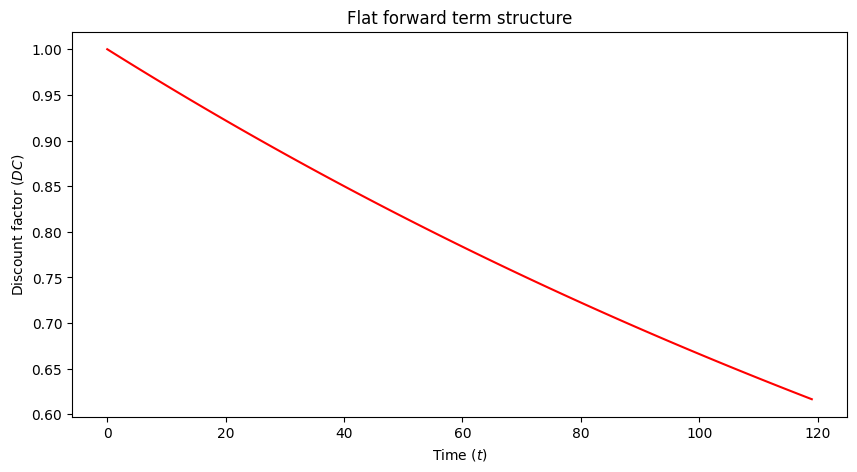

In [23]:
_ = pd.Series(d).plot(color="red")
_ = plt.title("Flat forward term structure")
_, _ = plt.xlabel("Time ($t$)"), plt.ylabel("Discount factor ($DC$)")

In [24]:
# TO BE FINISHED